<a href="https://colab.research.google.com/github/Hayyin26/PCVK_Ganjil_25-26/blob/main/PBLSMS5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libary

In [50]:
!python --version

Python 3.12.12


In [51]:
!pip install skl2onnx onnx onnxruntime

In [52]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import warnings
import joblib
import random
import onnxruntime as ort
from google.colab import files

warnings.filterwarnings('ignore')

# Load Gambar

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import os
import cv2
import numpy as np

def load_dataset(directory, img_size=(512, 512)):
    data = []
    labels = []

    # urutan kelas harus konsisten
    class_names = sorted(os.listdir(directory))
    print("Urutan kelas:", class_names)

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)

        if not os.path.isdir(class_folder):
            continue

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels), class_names

In [55]:
train_dir = "/content/drive/MyDrive/PBL_Dataset_Daun/train"
test_dir  = "/content/drive/MyDrive/PBL_Dataset_Daun/test"

X_train, y_train, class_names = load_dataset(train_dir)
X_test, y_test, _ = load_dataset(test_dir)

print("Train data :", X_train.shape)
print("Test data  :", X_test.shape)
print("Classes    :", class_names)


Urutan kelas: ['melengkung', 'menjari', 'menyirip', 'sejajar']
Urutan kelas: ['melengkung', 'menjari', 'menyirip', 'sejajar']
Train data : (1364, 512, 512, 3)
Test data  : (300, 512, 512, 3)
Classes    : ['melengkung', 'menjari', 'menyirip', 'sejajar']


In [56]:
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy for concatenation if not already in scope

# Combine X_train and X_test to form the full images dataset
images = np.concatenate((X_train, X_test), axis=0)

# Combine y_train and y_test to form the full labels dataset
labels = np.concatenate((y_train, y_test), axis=0)

X_train_img_73, X_test_img_73, y_train_str_73, y_test_str_73 = train_test_split(
    images,
    labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (70%): {len(X_train_img_73)}")
print(f"Jumlah Sampel Testing (30%): {len(X_test_img_73)}")

Jumlah Sampel Training (70%): 1164
Jumlah Sampel Testing (30%): 500


In [57]:
X_train_img_82, X_test_img_82, y_train_str_82, y_test_str_82 = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (80%): {len(X_train_img_82)}")
print(f"Jumlah Sampel Testing (20%): {len(X_test_img_82)}")

Jumlah Sampel Training (80%): 1331
Jumlah Sampel Testing (20%): 333


In [58]:
X_train_img_91, X_test_img_91, y_train_str_91, y_test_str_91 = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (90%): {len(X_train_img_91)}")
print(f"Jumlah Sampel Testing (10%): {len(X_test_img_91)}")

Jumlah Sampel Training (90%): 1497
Jumlah Sampel Testing (10%): 167


# Pre-processing (HSV)

In [59]:
def hsv_preprocessing(images, labels, label_map):
    hsv_img_list = []
    class_list = list_label.copy()
    for i, l in zip(images, labels):
      hsv_image = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
      color_hist = cv2.calcHist([hsv_image], [0, 1], None, [16, 8], [0, 180, 0, 256])

      cv2.normalize(color_hist, color_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

      color_features = color_hist.flatten()

      hsv_img_list.append(color_features)

      if l in class_list:
        class_list.remove(l)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"Analisis Gambar (Kelas: {l})", fontsize=16)

        img_rgb = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_rgb)
        axes[0].set_title("1. Gambar Asli (RGB)")
        axes[0].axis('off')

        h_channel = hsv_image[:, :, 0]

        axes[1].hist(h_channel.flatten(), bins=180, range=[0, 180], color='blue')
        axes[1].set_title("2. Histogram Persebaran Warna (Hue)")
        axes[1].set_xlabel("Nilai Hue (0-179)")
        axes[1].set_ylabel("Jumlah Piksel")
        axes[1].set_xlim([0, 180])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return hsv_img_list

In [60]:
print(sorted(set(y_train_str_73)))


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [61]:
list_label = [
    'melengkung',
    'menjari',
    'menyirip',
    'sejajar'
]

# Gunakan convert hanya jika label masih numeric
def convert_numeric_to_label(y_numeric, label_map):
    return [label_map[int(i)] for i in y_numeric]

# Hanya jalankan convert kalau label masih angka (np.int64)
if isinstance(list(y_train_str_73)[0], (int, np.integer)):
    y_train_str_73 = convert_numeric_to_label(y_train_str_73, list_label)

if isinstance(list(y_test_str_73)[0], (int, np.integer)):
    y_test_str_73  = convert_numeric_to_label(y_test_str_73, list_label)

if isinstance(list(y_train_str_82)[0], (int, np.integer)):
    y_train_str_82 = convert_numeric_to_label(y_train_str_82, list_label)

if isinstance(list(y_test_str_82)[0], (int, np.integer)):
    y_test_str_82  = convert_numeric_to_label(y_test_str_82, list_label)

if isinstance(list(y_train_str_91)[0], (int, np.integer)):
    y_train_str_91 = convert_numeric_to_label(y_train_str_91, list_label)

if isinstance(list(y_test_str_91)[0], (int, np.integer)):
    y_test_str_91  = convert_numeric_to_label(y_test_str_91, list_label)


In [62]:
print("Tipe isi:", type(y_train_str_73[0]))
print("Unique labels:", sorted(set(y_train_str_73)))


Tipe isi: <class 'str'>
Unique labels: ['melengkung', 'menjari', 'menyirip', 'sejajar']


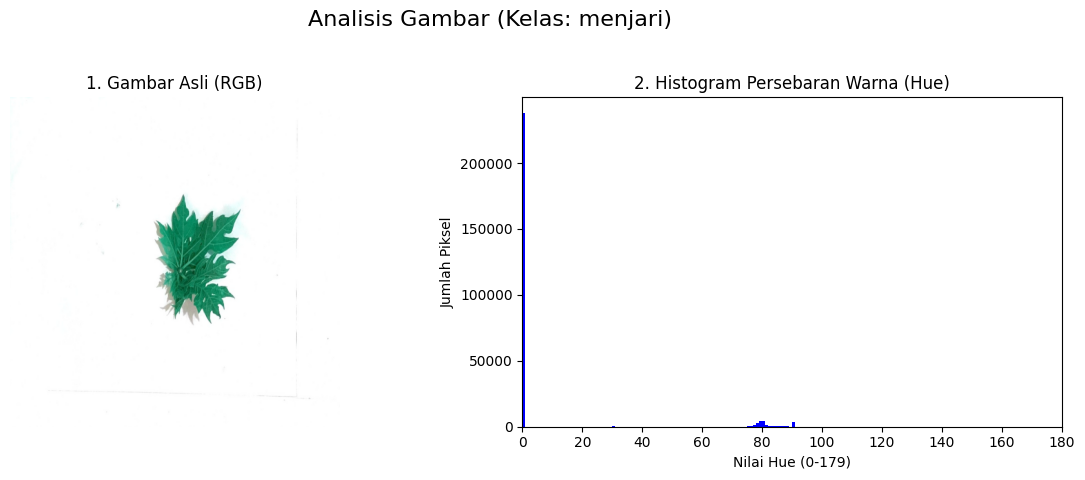

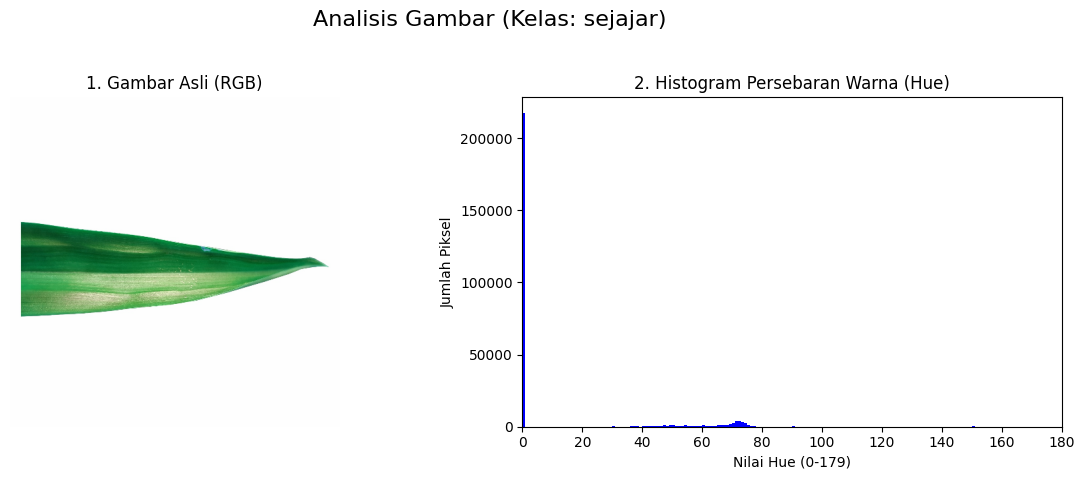

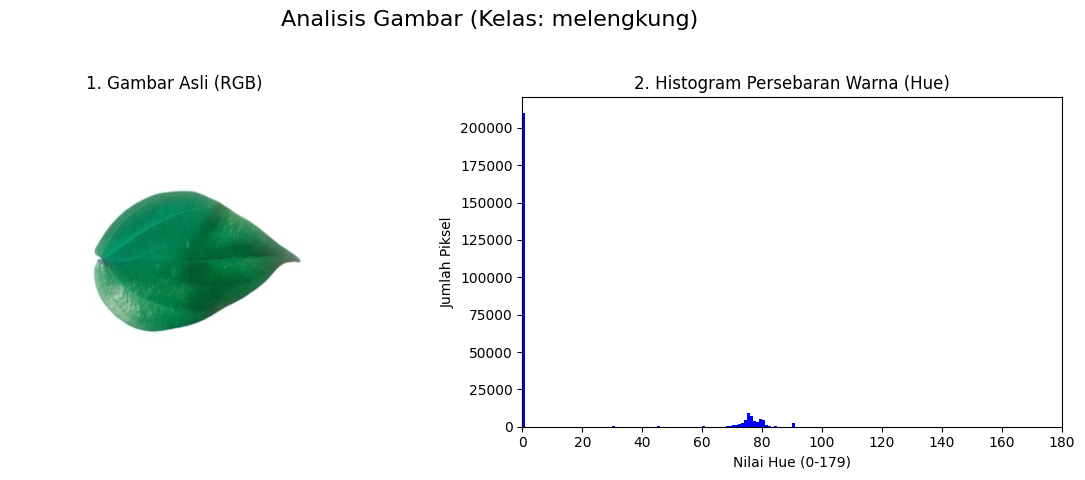

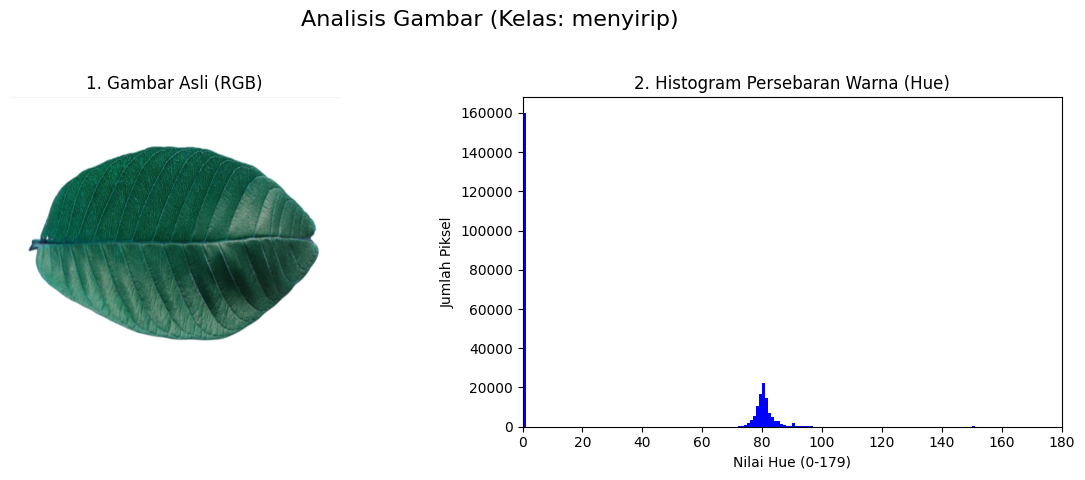

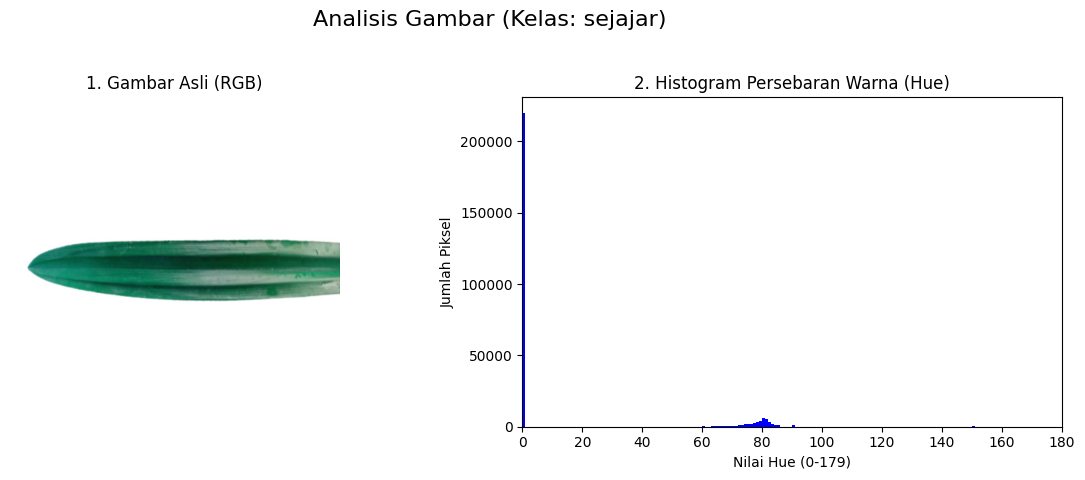

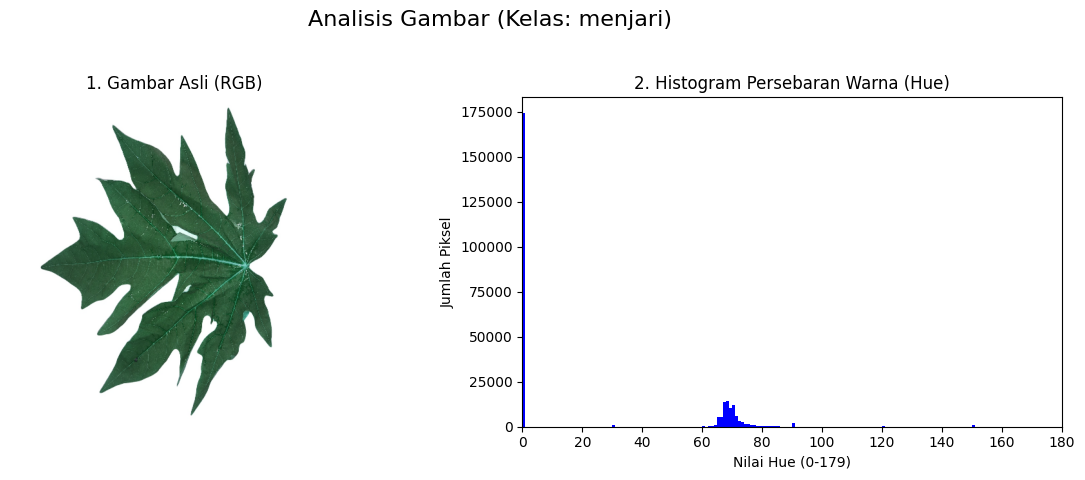

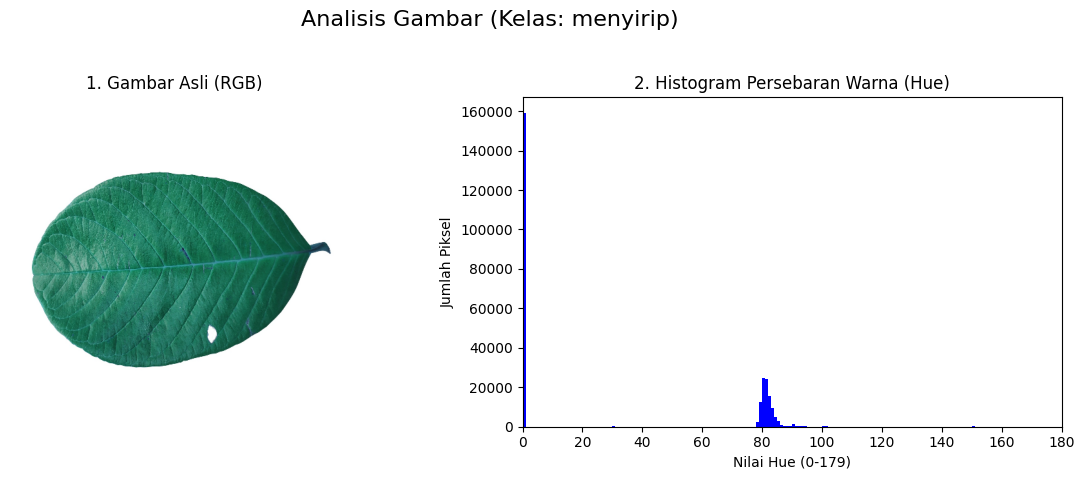

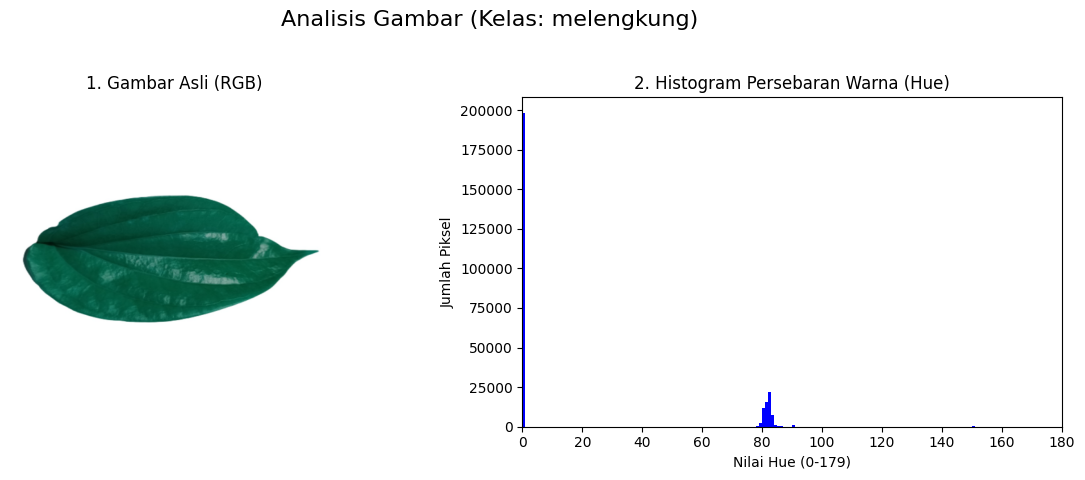

In [63]:
train_hsv_73 = hsv_preprocessing(X_train_img_73, y_train_str_73, list_label)
test_hsv_73  = hsv_preprocessing(X_test_img_73, y_test_str_73, list_label)

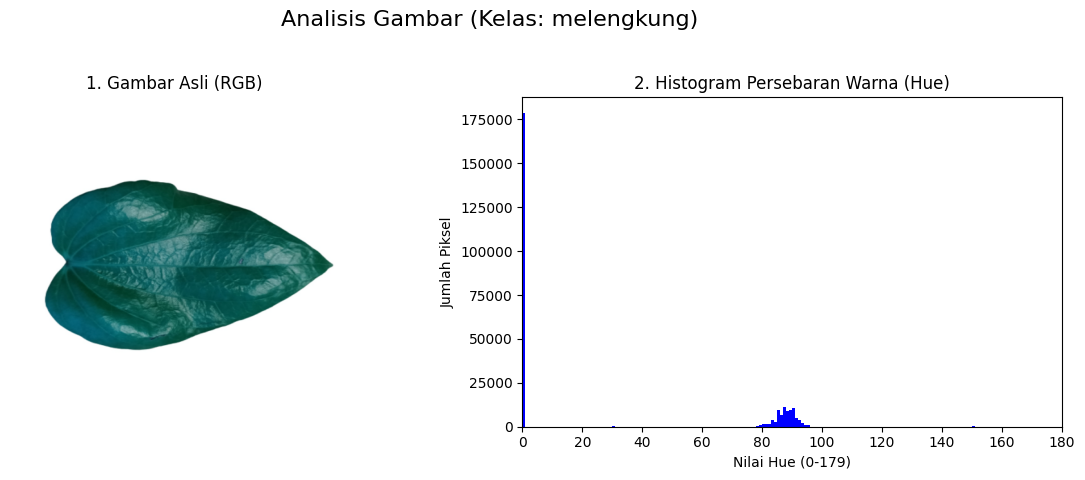

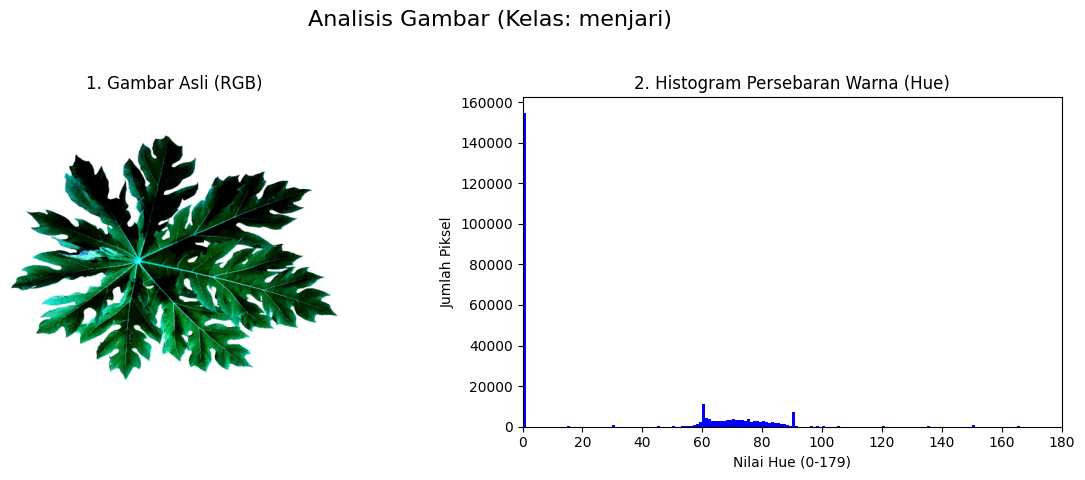

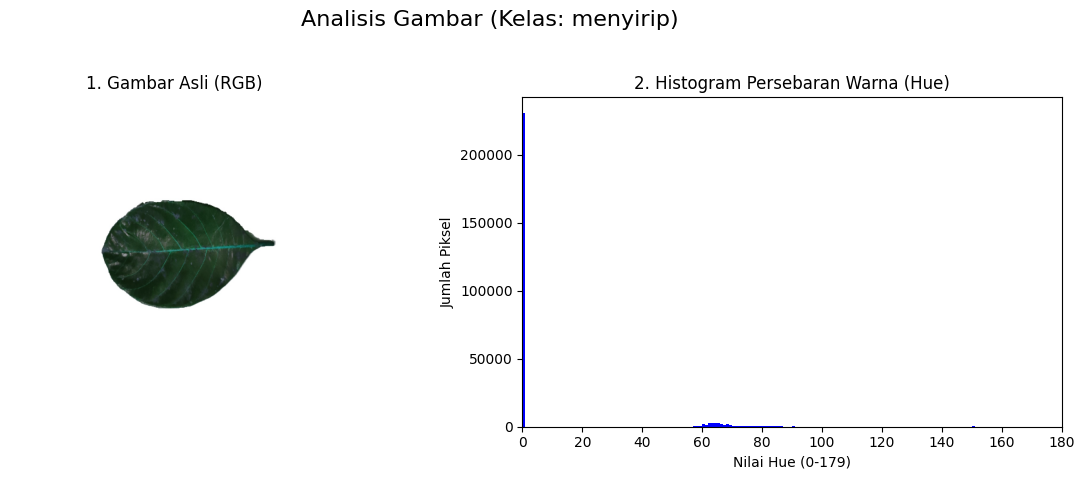

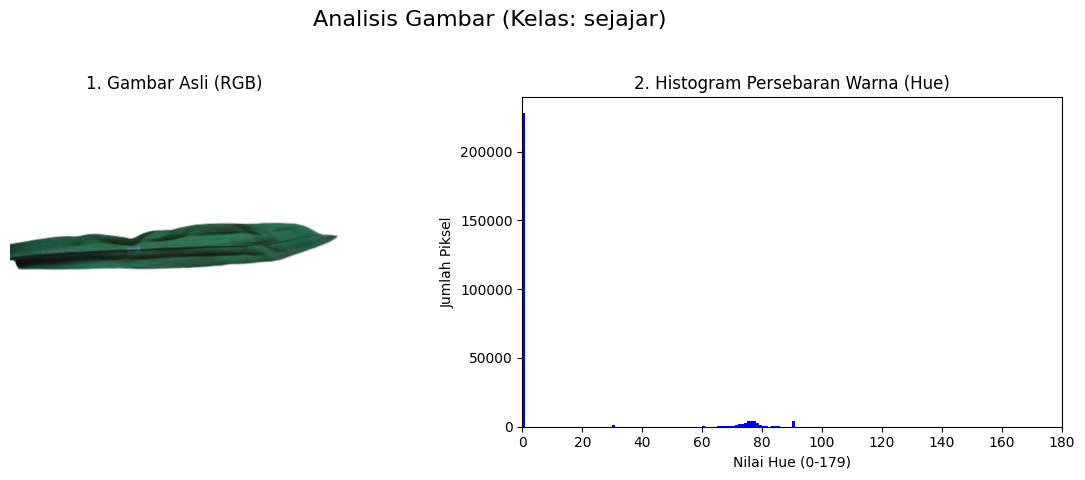

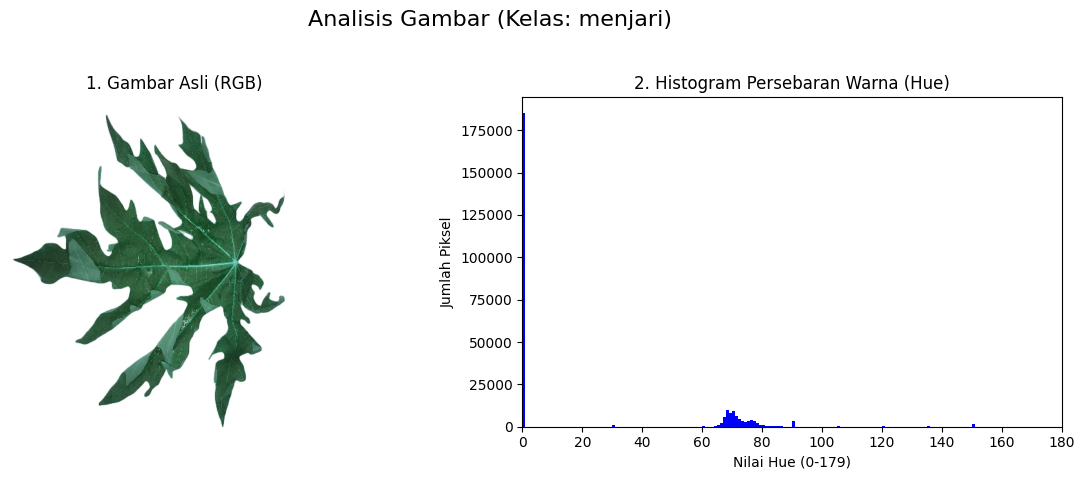

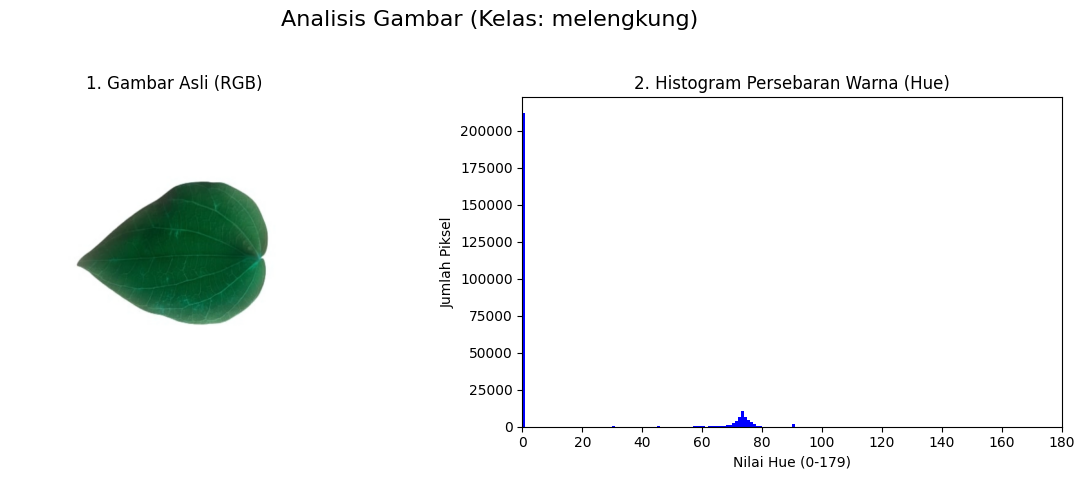

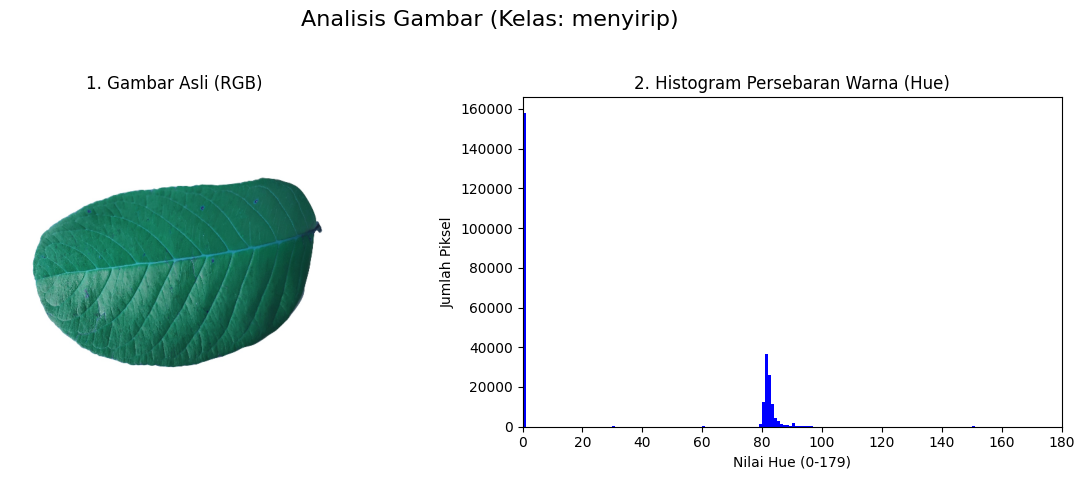

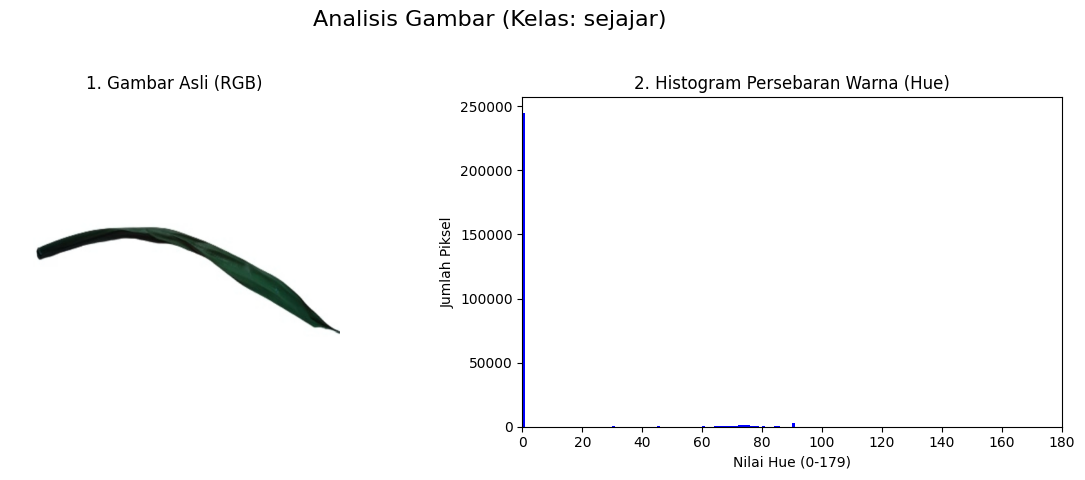

In [64]:
train_hsv_82 = hsv_preprocessing(X_train_img_82, y_train_str_82, list_label)
test_hsv_82 = hsv_preprocessing(X_test_img_82, y_test_str_82, list_label)

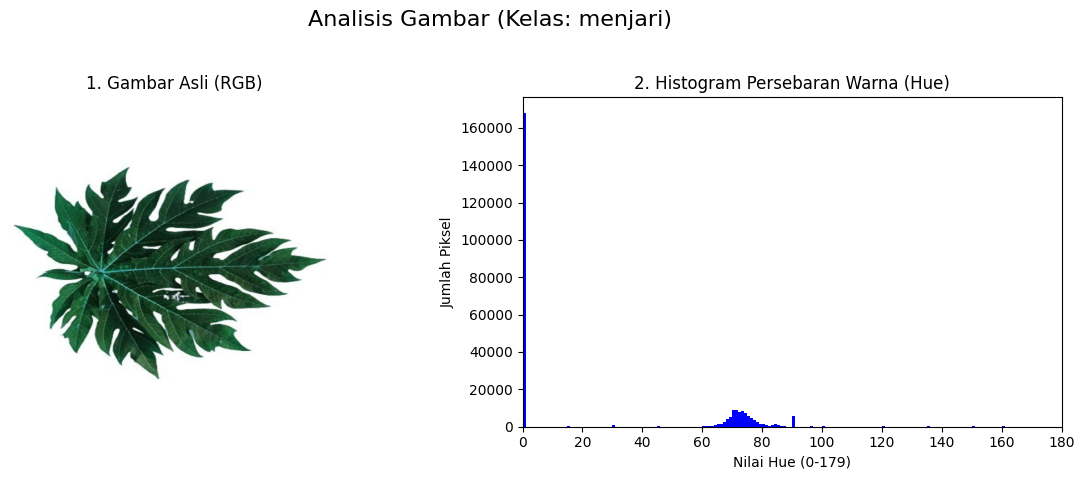

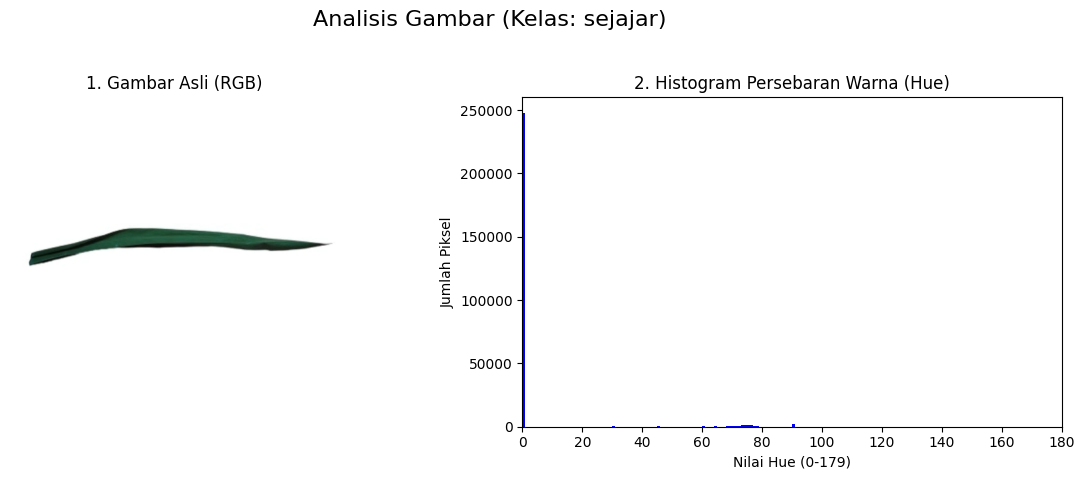

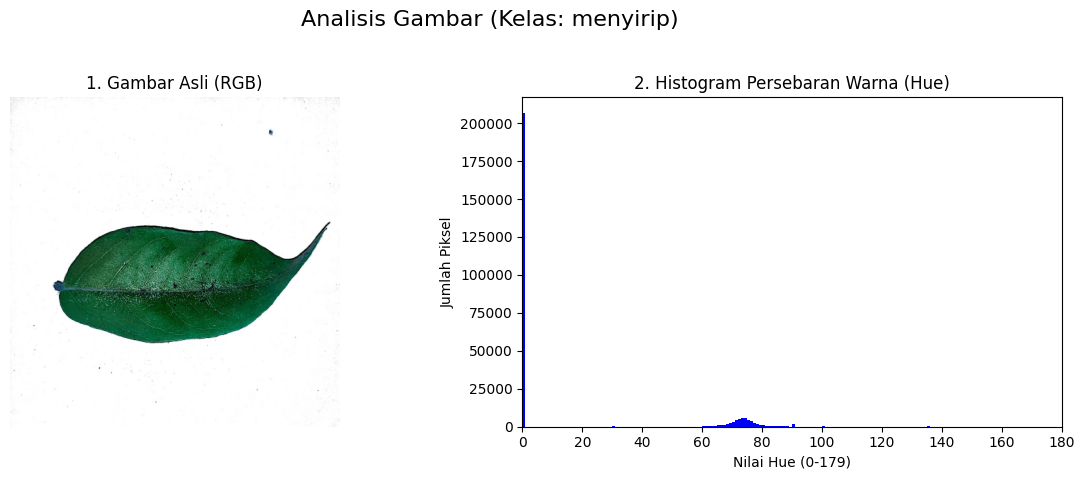

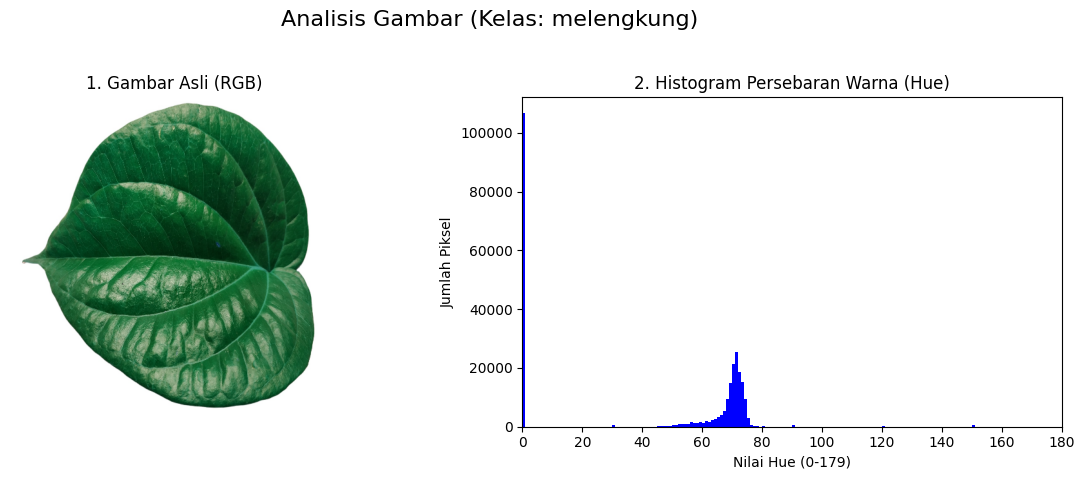

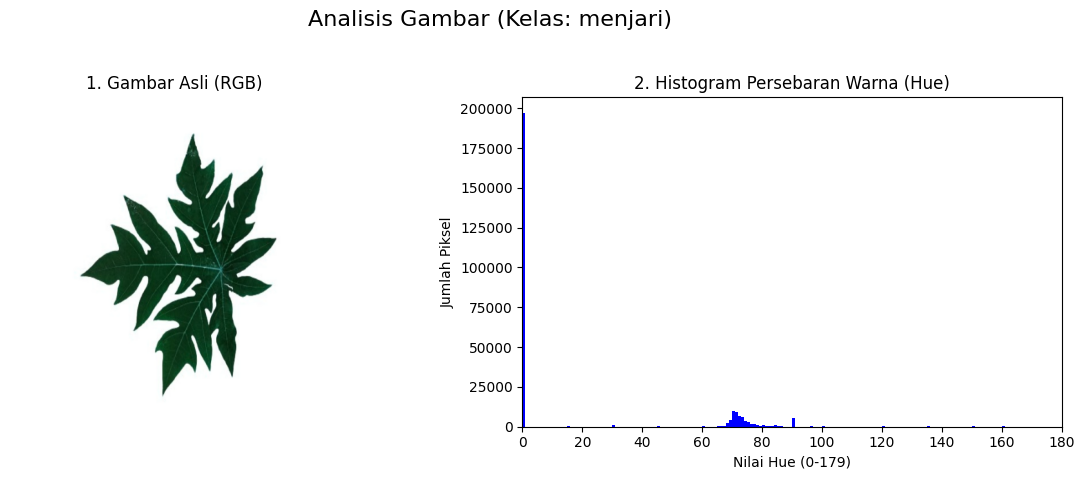

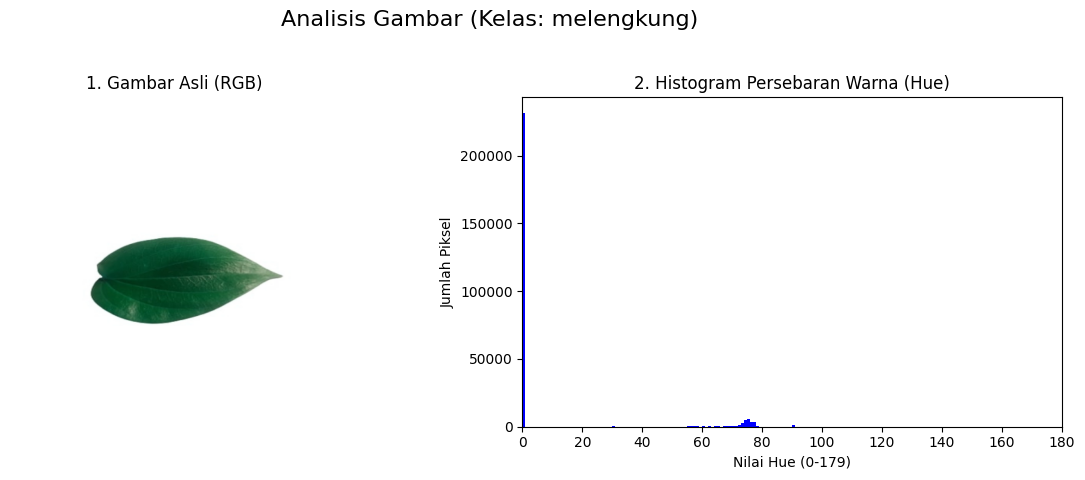

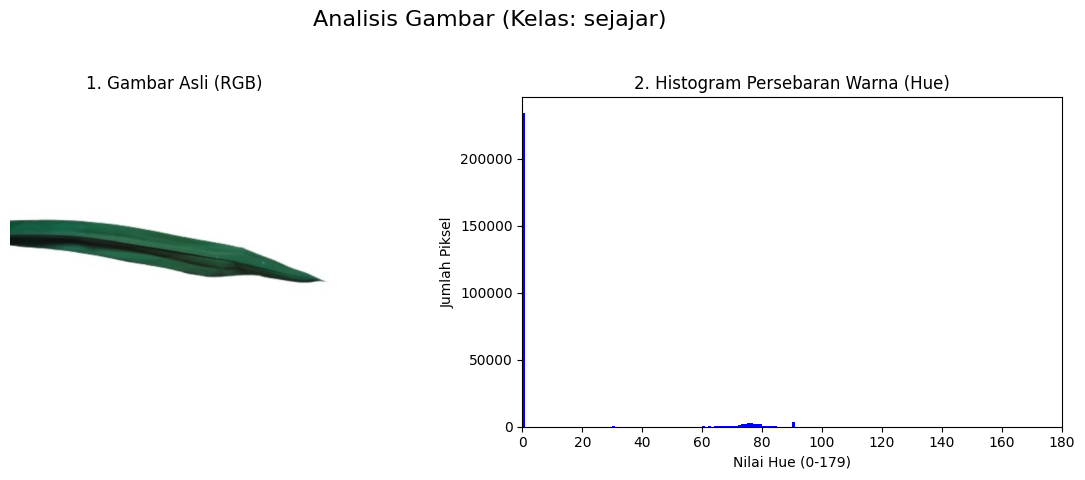

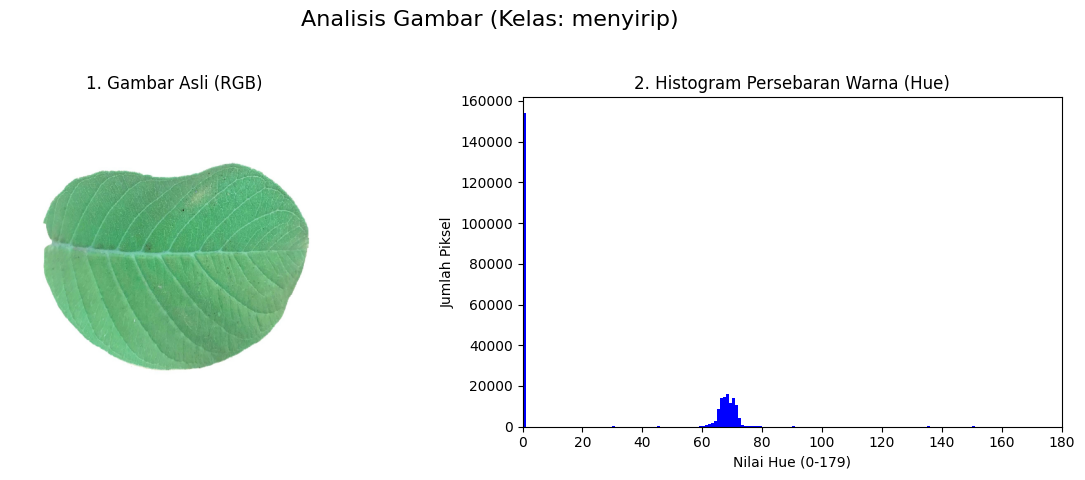

In [65]:
train_hsv_91 = hsv_preprocessing(X_train_img_91, y_train_str_91, list_label)
test_hsv_91 = hsv_preprocessing(X_test_img_91, y_test_str_91, list_label)

#HOG

In [66]:
from skimage.color import rgb2gray
from skimage.feature import hog
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hog_feature_extraction(images, labels, list_label):
    hog_img_list = []
    class_list = list_label.copy()

    for img, label in zip(images, labels):

        # 1. Convert BGR → RGB untuk display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 4. Grayscale
        gray = rgb2gray(img_rgb)

        # 5. Edge detection → memperjelas shape daun
        edges = cv2.Canny((gray * 255).astype(np.uint8), 50, 150)

        # 6. HOG Feature extraction (input: edge image)
        hog_features, hog_visual = hog(
            edges,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )

        hog_img_list.append(hog_features)

        # --- Visualisasi (hanya 1 per class) ---
        if label in class_list:
            class_list.remove(label)

            fig, axes = plt.subplots(1, 4, figsize=(23, 5))
            fig.suptitle(f"Visualisasi Tahapan Ekstraksi Fitur {label}", fontsize=16)

            axes[0].imshow(img_rgb)
            axes[0].set_title(f"1. Asli\n{img.shape}")
            axes[0].axis("off")

            axes[1].imshow(gray, cmap="gray")
            axes[1].set_title("2. Grayscale")
            axes[1].axis("off")

            axes[2].imshow(edges, cmap="gray")
            axes[2].set_title("3. Edge Detection (Canny)")
            axes[2].axis("off")

            axes[3].imshow(hog_visual, cmap="gray")
            axes[3].set_title("4. HOG")
            axes[3].axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show()

    return hog_img_list

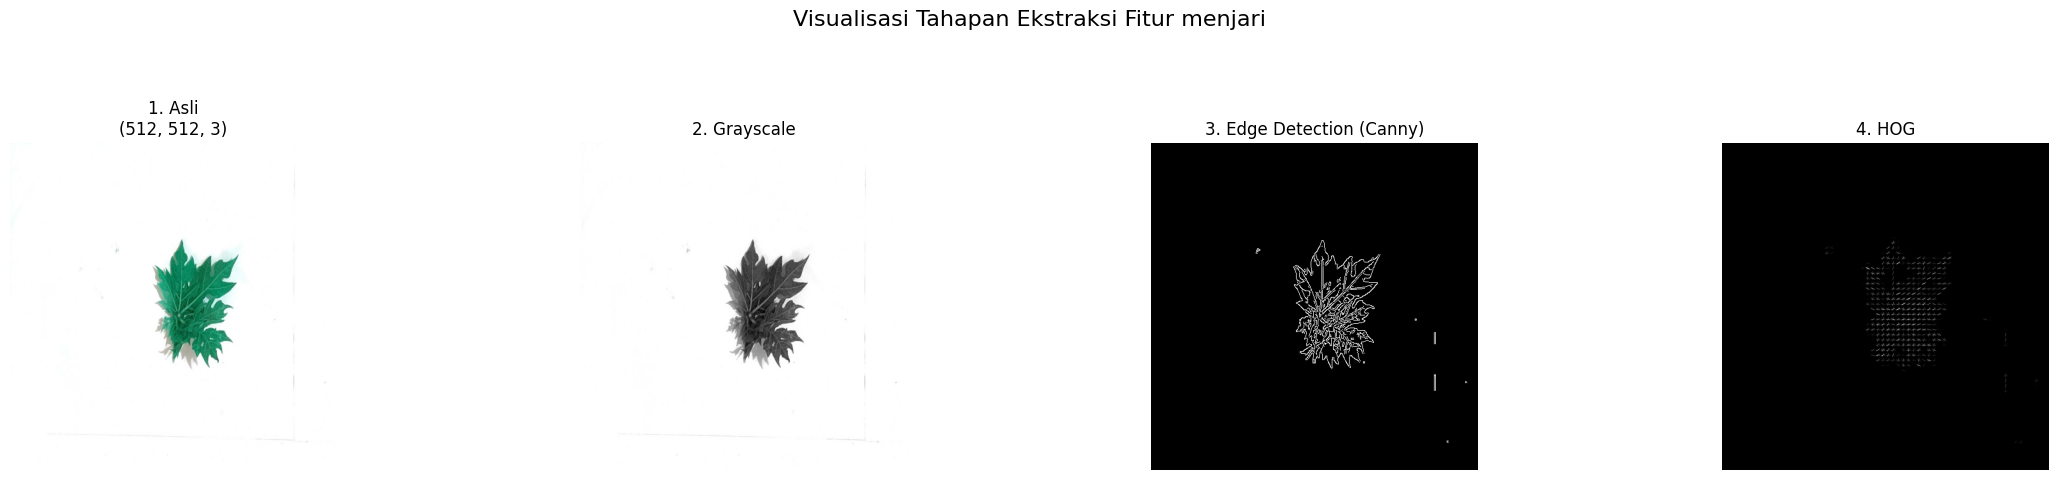

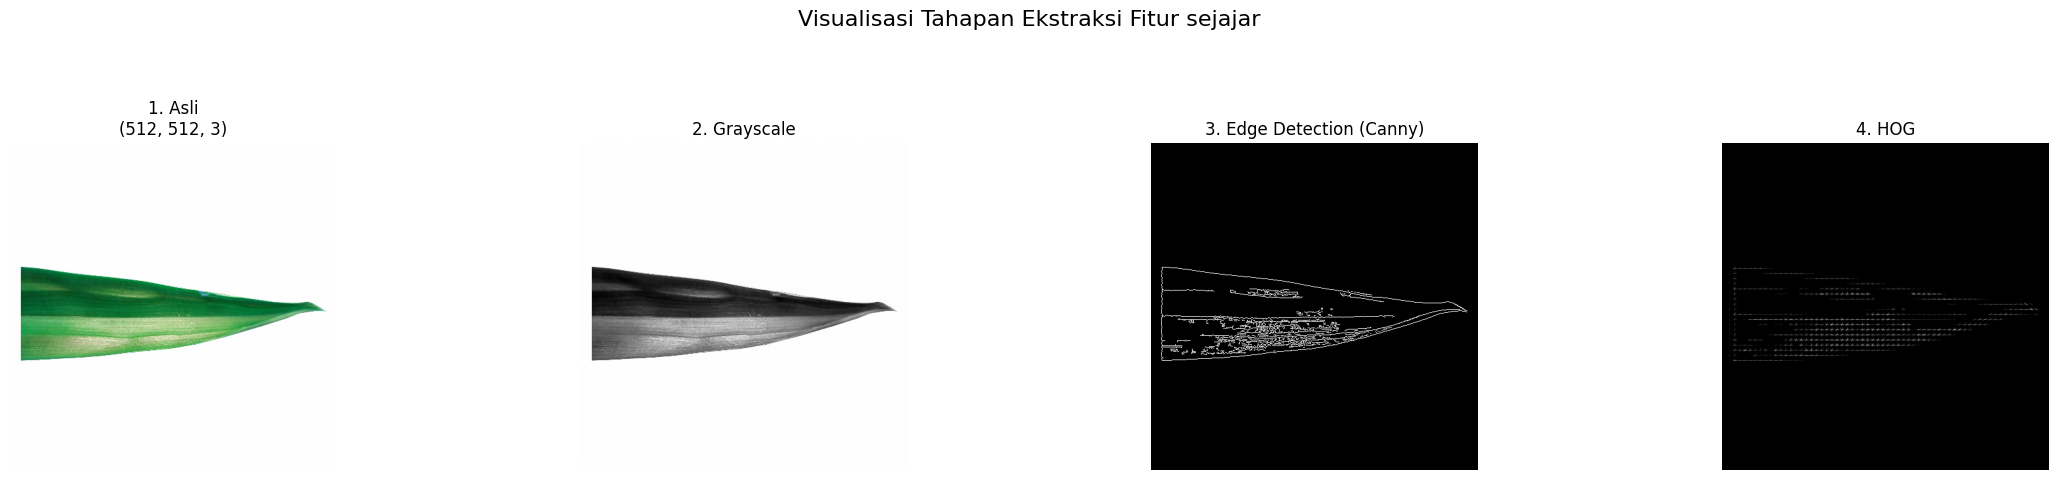

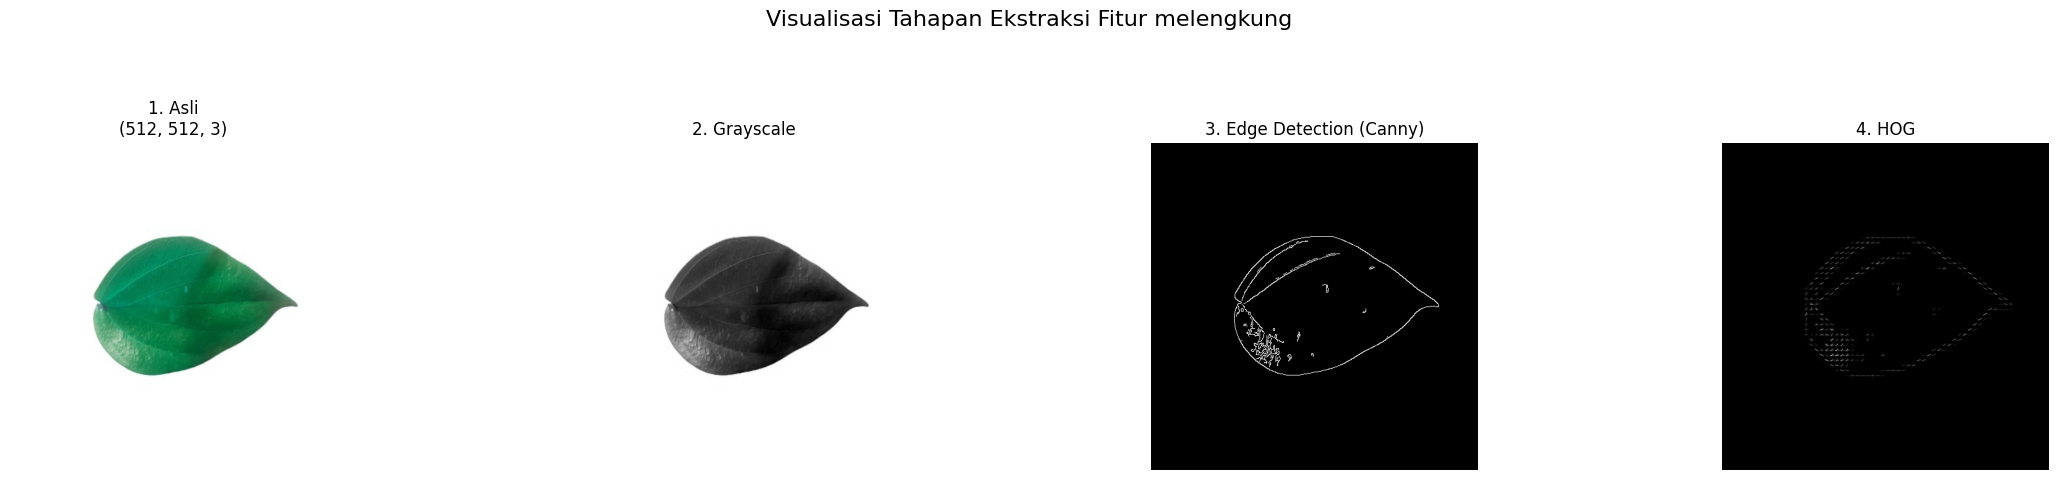

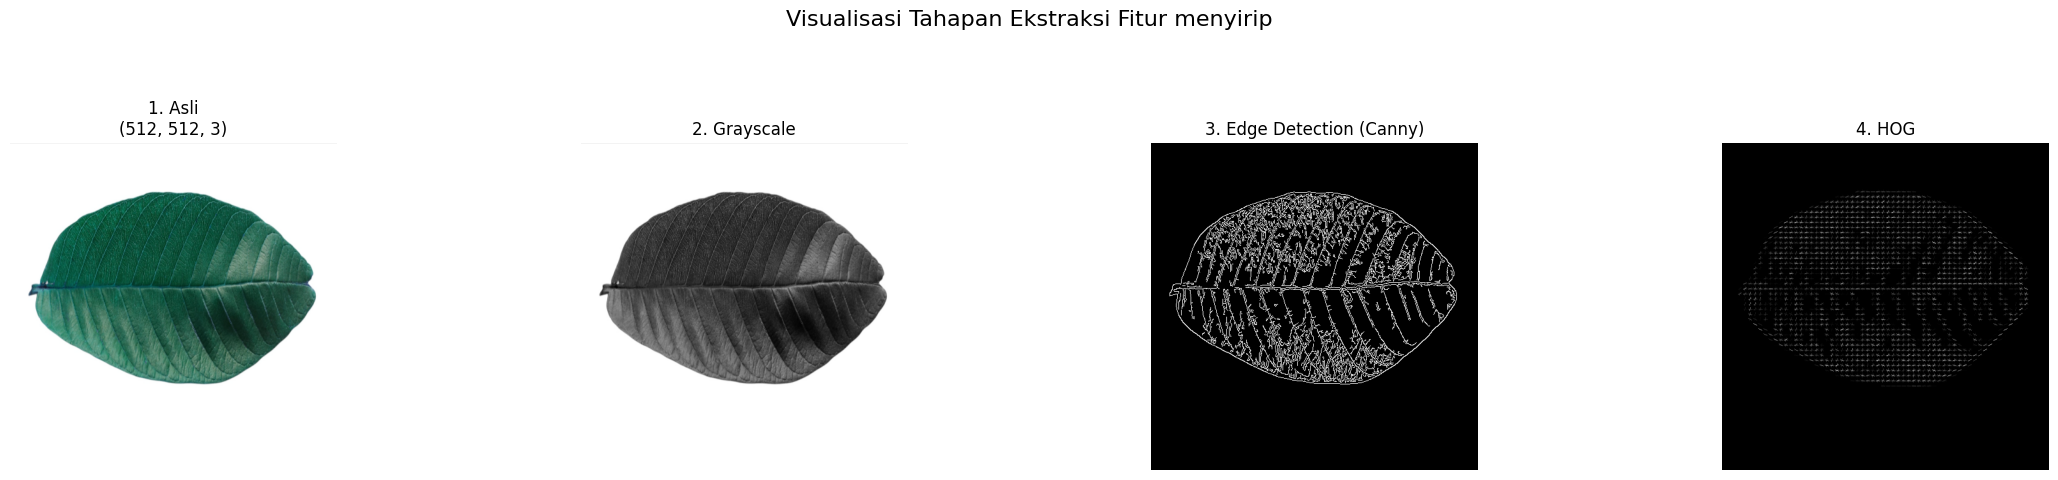

KeyboardInterrupt: 

In [67]:
train_hog_73 = hog_feature_extraction(X_train_img_73, y_train_str_73, list_label)
test_hog_73 = hog_feature_extraction(X_test_img_73, y_test_str_73, list_label)

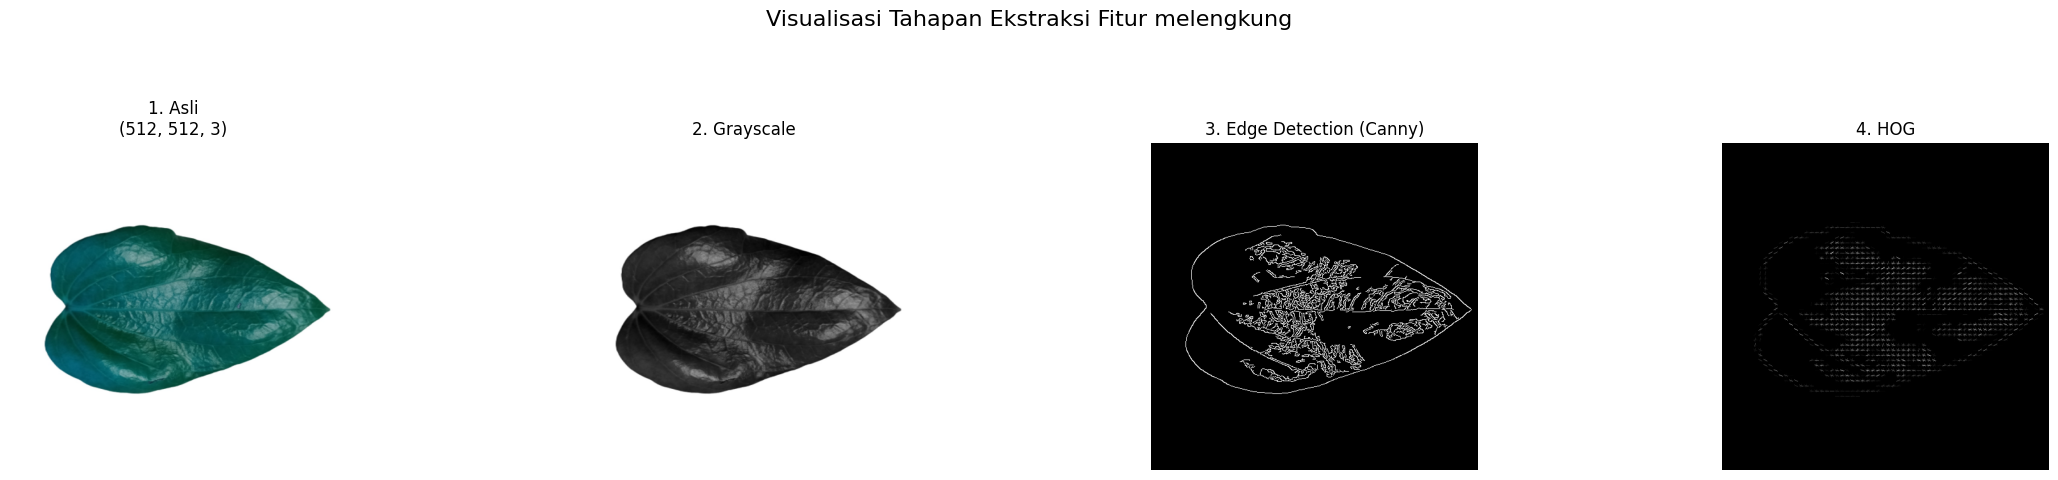

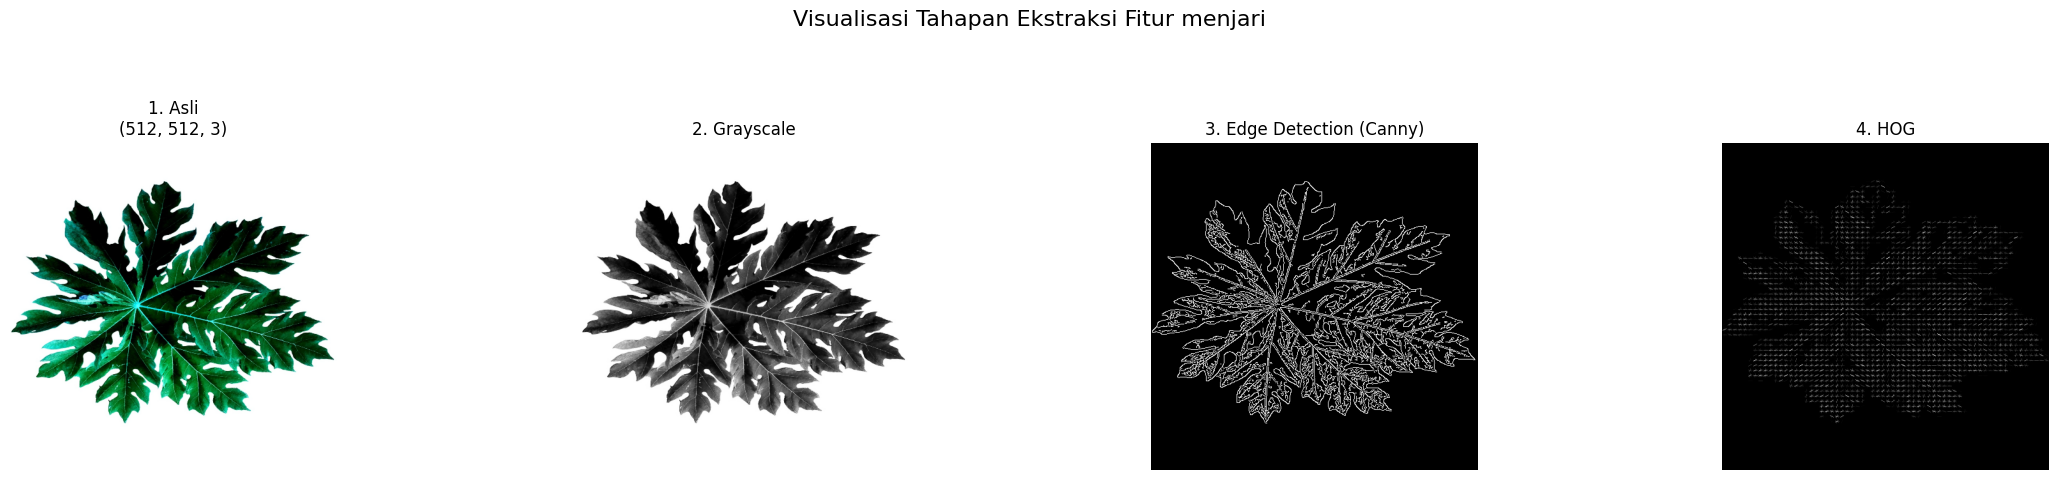

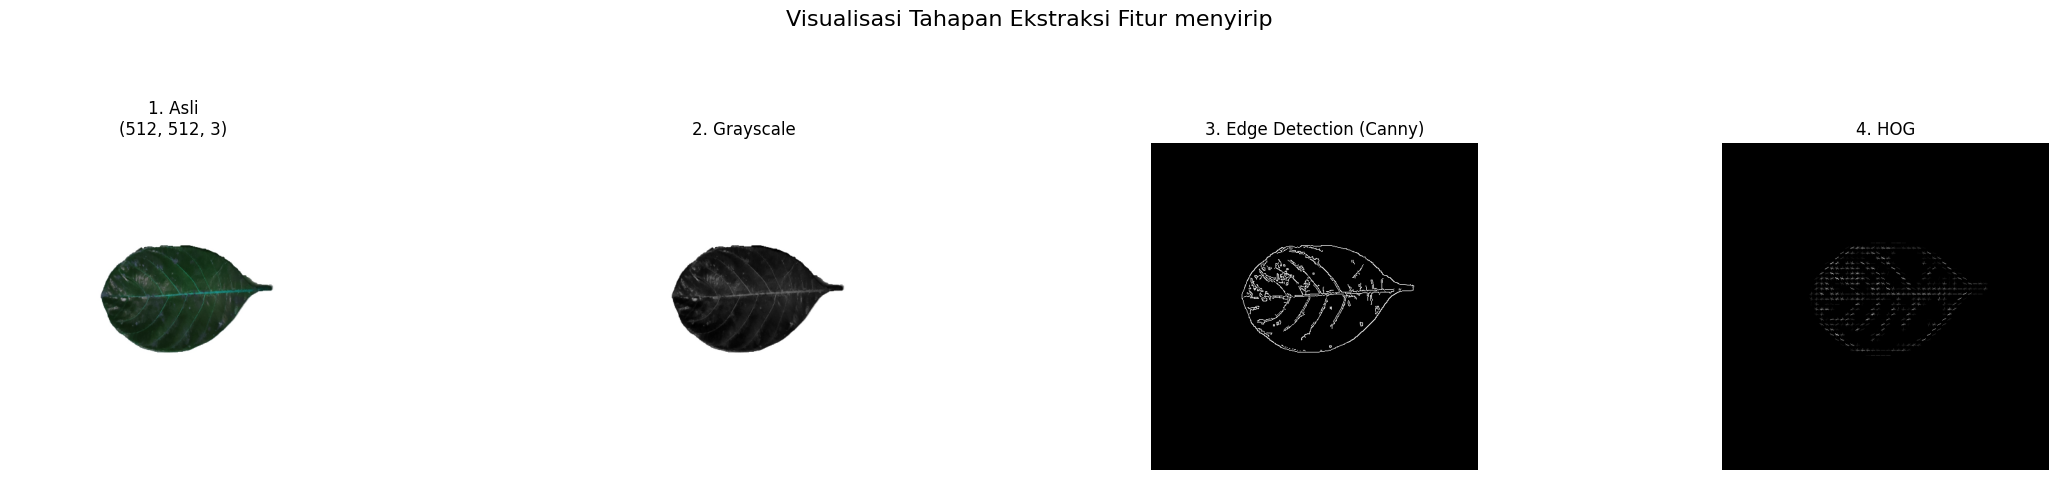

KeyboardInterrupt: 

In [68]:
train_hog_82 = hog_feature_extraction(X_train_img_82, y_train_str_82, list_label)
test_hog_82 = hog_feature_extraction(X_test_img_82, y_test_str_82, list_label)

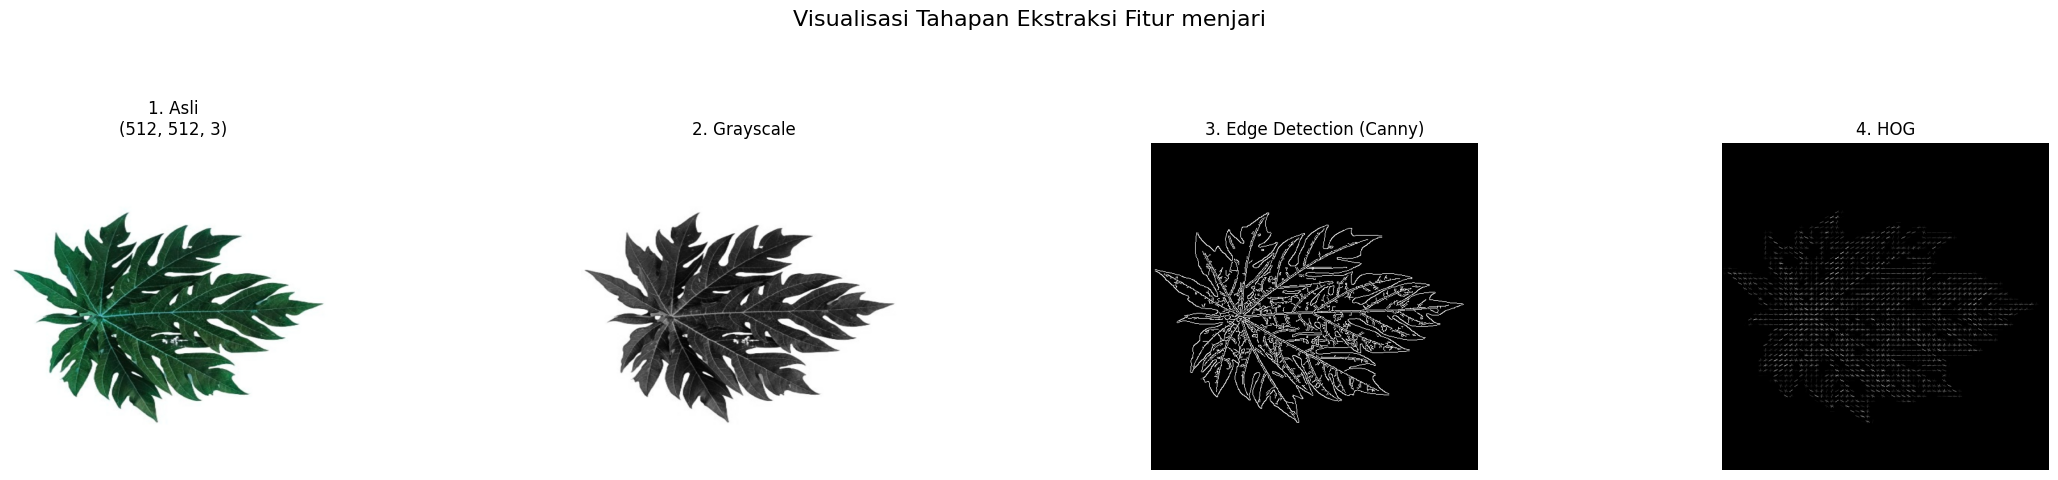

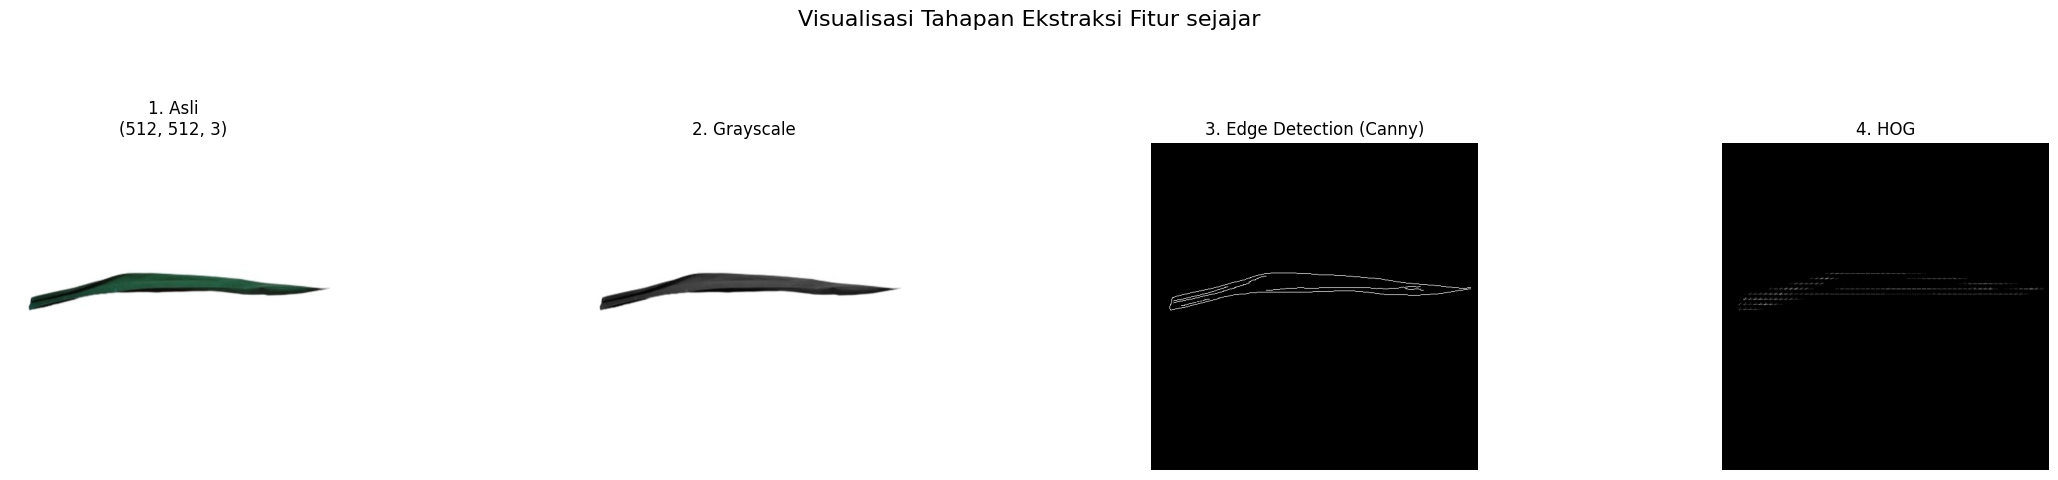

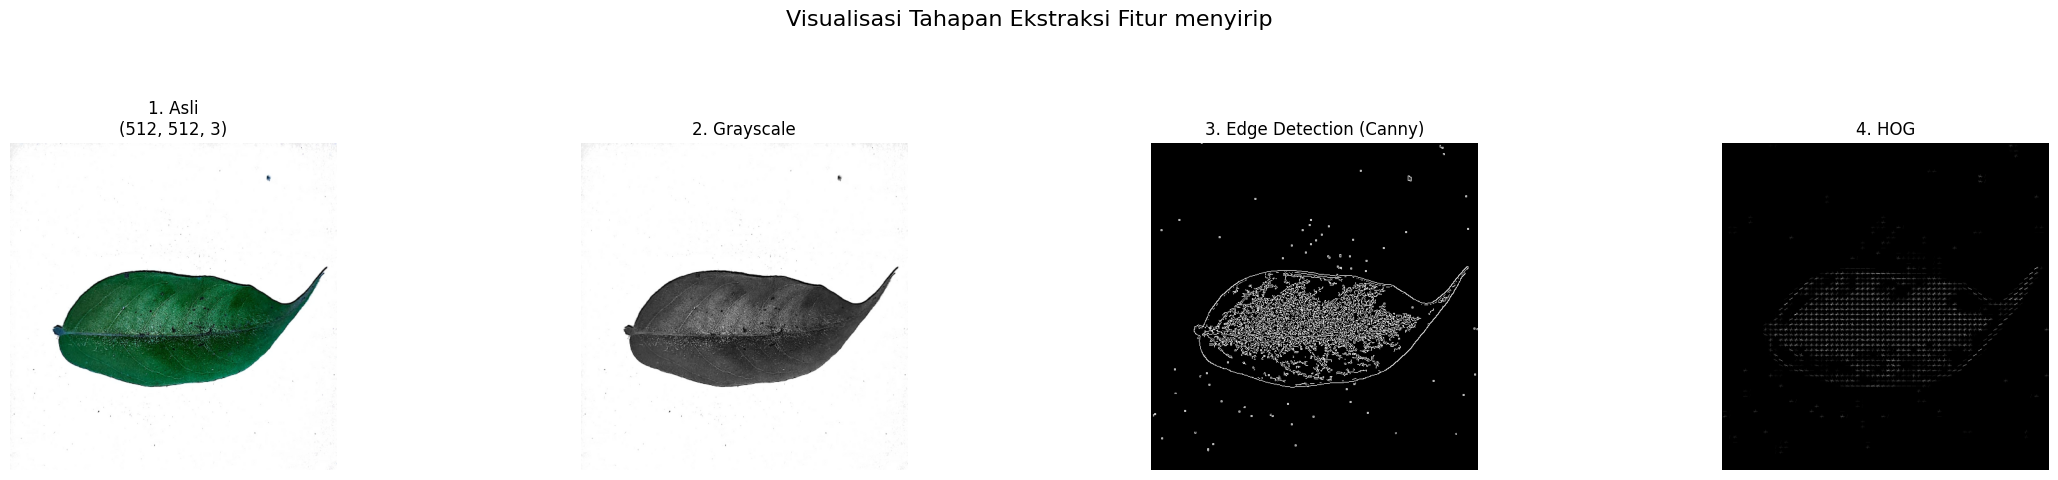

KeyboardInterrupt: 

In [69]:
train_hog_91 = hog_feature_extraction(X_train_img_91, y_train_str_91, list_label)
test_hog_91 = hog_feature_extraction(X_test_img_91, y_test_str_91, list_label)

In [70]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize
from skimage.feature import hog
import cv2
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# 1. Homomorphic Filtering
# -----------------------------------------------------------
def homomorphic_filter(gray):
    gray = gray.astype(np.float32) / 255.0
    log_img = np.log1p(gray)

    M, N = log_img.shape
    sigma = 30

    u = np.arange(M)
    v = np.arange(N)
    U, V = np.meshgrid(u, v, indexing='ij')

    D2 = (U - M/2)*2 + (V - N/2)*2
    H = 1 - np.exp(-D2 / (2 * sigma * sigma))

    F = np.fft.fftshift(np.fft.fft2(log_img))
    G = H * F
    out = np.fft.ifft2(np.fft.ifftshift(G))
    homomorphic = np.expm1(np.real(out))

    homomorphic = cv2.normalize(homomorphic, None, 0, 255, cv2.NORM_MINMAX)
    return homomorphic.astype(np.uint8)


# -----------------------------------------------------------
# 2. Kirsch Operator (edge 8 arah)
# -----------------------------------------------------------
def kirsch_edge(gray):
    kirsch_kernels = [
        np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
        np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]),
        np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),
        np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),
        np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),
        np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),
        np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),
        np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),
    ]

    edges = np.zeros_like(gray)
    for k in kirsch_kernels:
        edge = cv2.filter2D(gray, -1, k)
        edges = np.maximum(edges, edge)

    return edges


# -----------------------------------------------------------
# 3. Main HOG Extraction Function
# -----------------------------------------------------------
def hog_feature_extraction(images, labels, list_label):
    hog_img_list = []
    class_list = list_label.copy()

    for img, label in zip(images, labels):

        # Convert BGR → RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 1. Grayscale
        gray = rgb2gray(img_rgb)
        gray_uint8 = (gray * 255).astype(np.uint8)

        # 2. Homomorphic filtering
        homo = homomorphic_filter(gray_uint8)

        # 3. CLAHE untuk menonjolkan urat daun
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_img = clahe.apply(homo)

        # 4. Kirsch Edge Detection (lebih kuat dari Canny)
        kirsch_edges = kirsch_edge(clahe_img)

        # 5. Adaptive threshold → segmentasi urat
        th = cv2.adaptiveThreshold(
            kirsch_edges, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            15, -2
        )

        # 6. Morphology Cleaning
        kernel = np.ones((3,3), np.uint8)
        clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)

        # 7. Skeletonization
        skeleton = skeletonize(clean > 0)

        # 8. HOG Feature extraction (pakai skeleton)
        hog_features, hog_visual = hog(
            skeleton,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )

        hog_img_list.append(hog_features)

        # ---------------- VISUALISASI ----------------
        if label in class_list:
            class_list.remove(label)

            fig, axes = plt.subplots(1, 8, figsize=(33, 5))
            fig.suptitle(f"Pipeline Ekstraksi Urat Daun ({label})", fontsize=16)

            images_vis = [
                (img_rgb, "1. Original RGB"),
                (gray, "2. Grayscale"),
                (homo, "3. Homomorphic Filter"),
                (clahe_img, "4. CLAHE"),
                (kirsch_edges, "5. Kirsch Edge"),
                (clean, "6. Cleaned Mask"),
                (skeleton, "7. Skeleton"),
                (hog_visual, "8. HOG Visual")
            ]

            for ax, (im, title) in zip(axes, images_vis):
                ax.imshow(im, cmap="gray")
                ax.set_title(title)
                ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show()

    return hog_img_list

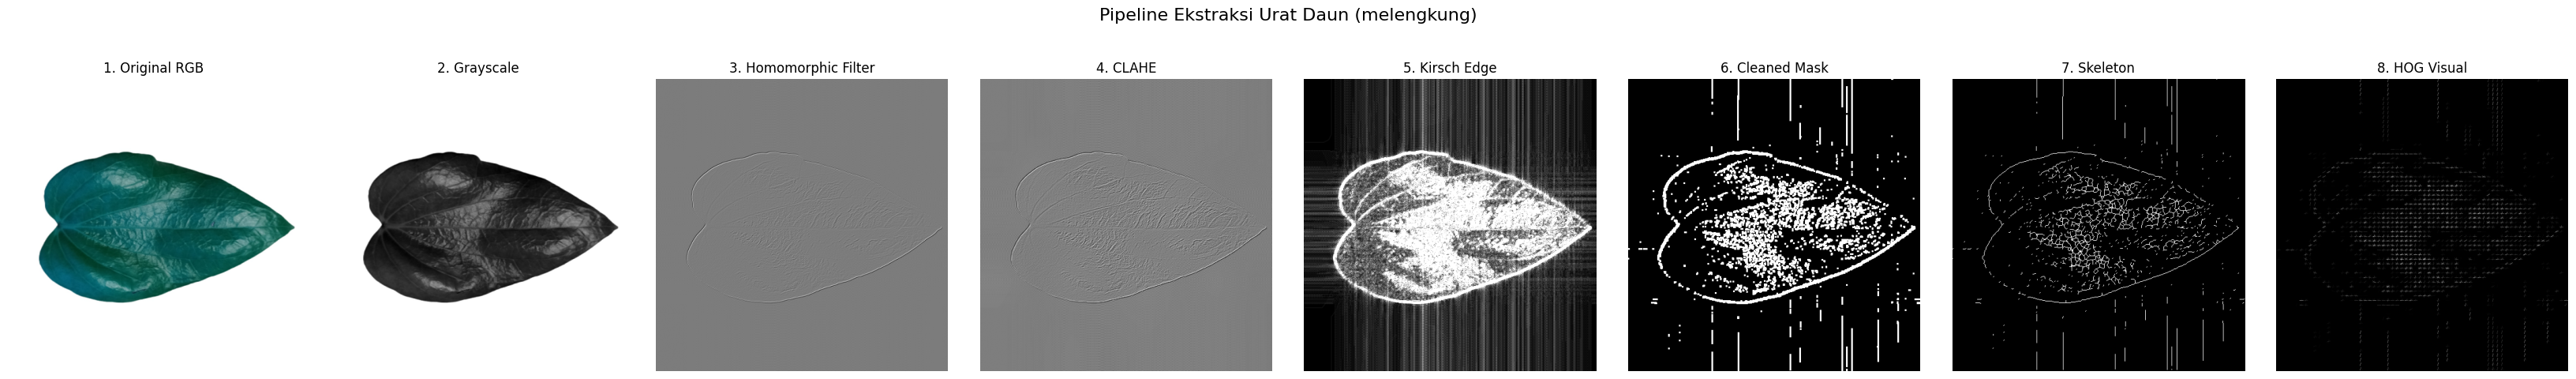

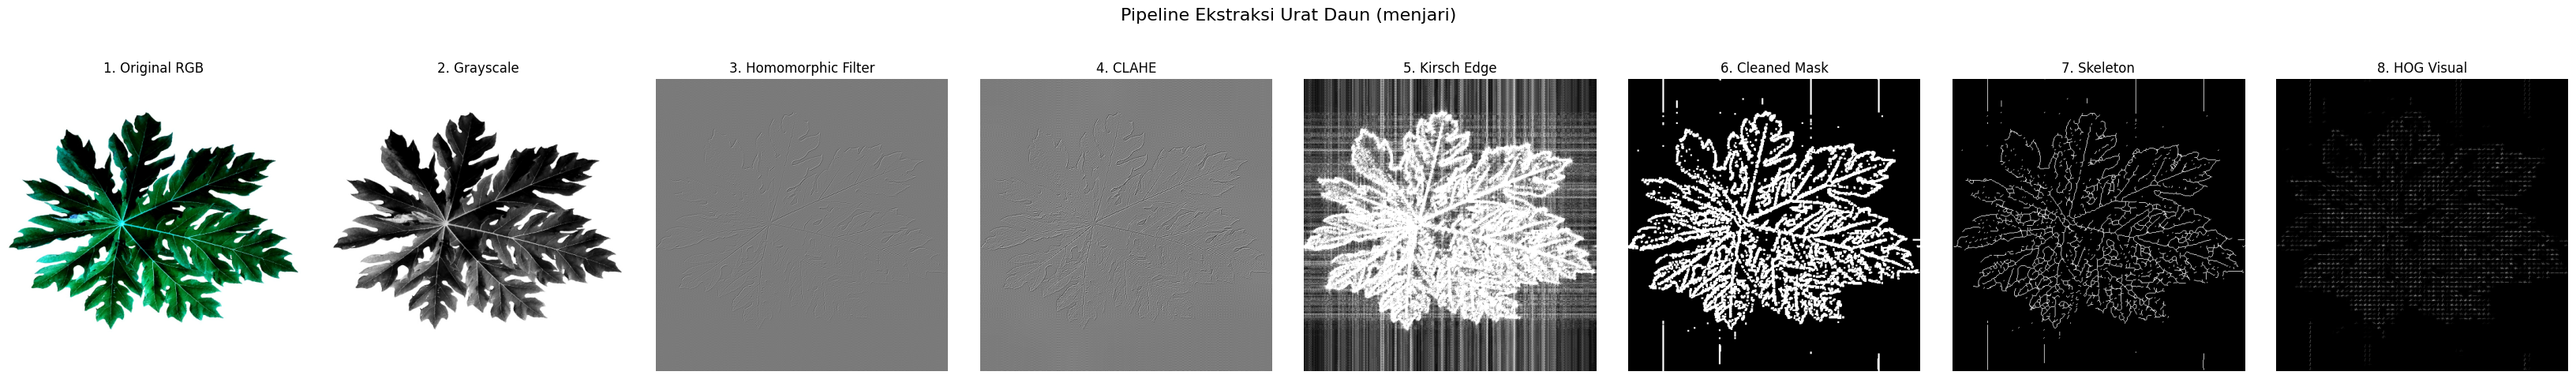

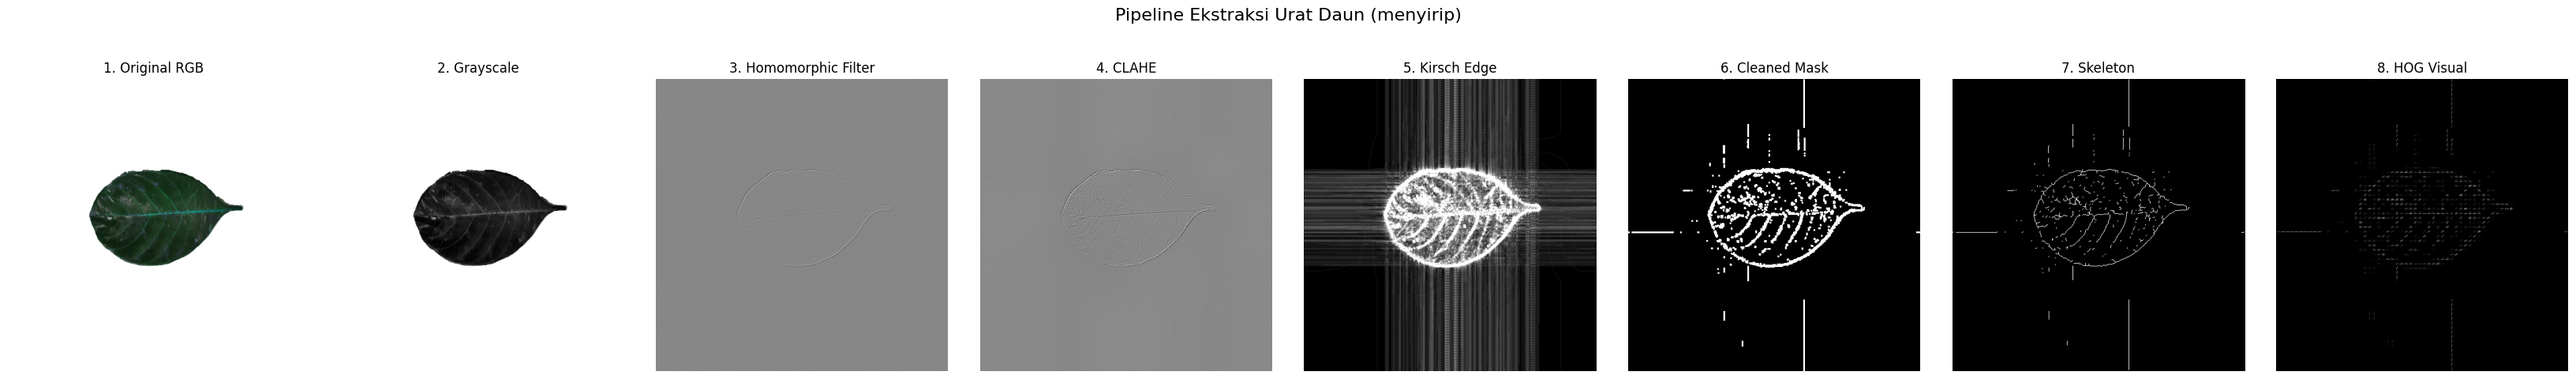

KeyboardInterrupt: 

In [71]:
train_hog_82 = hog_feature_extraction(X_train_img_82, y_train_str_82, list_label)
test_hog_82 = hog_feature_extraction(X_test_img_82, y_test_str_82, list_label)